# Image classification in Python

In the previous week, we computed some band indices and learnt that positive NDWI values were likely to be associated with water (e.g lakes, rivers, ocean). But what if someone wanted to know how much water was in the image? To do this, we would first have to classify pixels that are likely to be water. In this week, we will learn how to do this, and other quantitative analysis, by combining raster and vector data. 

In [45]:
# Import packages
import glob
import numpy as np
import rasterio
import matplotlib.pyplot as plt

# Define list of Landsat bands
files = sorted(glob.glob('data/landsat/*.tif'))
files

['data/landsat/band1.tif',
 'data/landsat/band2.tif',
 'data/landsat/band3.tif',
 'data/landsat/band4.tif',
 'data/landsat/band5.tif',
 'data/landsat/band6.tif',
 'data/landsat/band7.tif']

## Preparing data

We first need to produce a true color image so that we can identify our classes. Below is an example of exporting a true color image as a GeoTIFF that can be imported into QGIS. Although note that any combination of bands could be exported (e.g. color infrared) depending on what features we would like to identify. 

In [8]:
# Define paths to data
src_2 = rasterio.open(files[1])
band_2 = src_2.read(1)
src_3 = rasterio.open(files[2])
band_3 = src_3.read(1)
src_4 = rasterio.open(files[3])
band_4 = src_4.read(1)

# Write true color image
meta = {'driver': "GTiff",
        'height': band_2.shape[0],
        'width': band_2.shape[1],
        'count': 3,
        'dtype': band_2.dtype,
        'crs': src_2.crs,
        'transform':src_2.transform}
        
with rasterio.open("data/true-color.tif", 'w', **meta) as dst:
    dst.write(band_4, 1)
    dst.write(band_3, 2)
    dst.write(band_2, 3)

## Produce training dataset

Next, we will import the GeoTIFF into QGIS and generate a training dataset that we can use for our supervised classification. The easiest way to do this is to create polygons that contain our features of interest and save it as a shapefile layer.

```{image} images/create-layer.png
:alt: create shapefile layer
:class: bg-primary mb-1
:width: 600px
:align: center
```

In this example, we will make a new shapefile called `lake.shp`, making sure that **Geometry type** is set to `Polygon` and the **CRS** is set to the **same as our Lansdat true color image**. In our case, this is `WGS 84 / UTM Zone 10N`. 

```{image} images/layer-attributes.png
:alt: create shapefile layer
:class: bg-primary mb-1
:width: 600px
:align: center
```

Once we have created a new shapefile, we can edit it by selecting it in the **Layers** panel (i.e. by left-clicking it once) and clicking **Toggle Editing** (the little pencil button). 

```{image} images/toggle.png
:alt: toggle editing
:class: bg-primary mb-1
:width: 600px
:align: center
```

Now we can click the **Add Polygon Feature** button to the right of the **Toggle Editing** button to make a new polyon. Digitize a small area within the feature of interest (in our case, some pixels in the lake), set the **id** to 1 (although it doesn't matter which number we choose), and click **OK**. Repeat this step, to sample several lakes in our image. 

```{image} images/digitize-polygon.png
:alt: digitize
:class: bg-primary mb-1
:width: 600px
:align: center
```

When we feel good about our training dataset, we can click the **Toggle Editing** button again to save our shapefile. We can then repeat this procedure for every feature that we want to classify. In our example, we have digitized seven features that include: lake, forest, cleared, river, sand, ocean, and grass. 

```{image} images/classes.png
:alt: digitize
:class: bg-primary mb-1
:width: 200px
:align: center
```

## Masking raster data using shapefile

We now should have several shapefiles containing polygons that outline our features of interest. We can read them using Python using the `GeoPandas` package. 

In [9]:
import geopandas as gpd
lake = gpd.read_file('data/lake.shp')
lake

,id,geometry
0,1,"POLYGON ((411681.33 4858920.1, 412387.6 485888..."
1,2,"POLYGON ((409741.747 4847556.896, 409822.866 4..."
2,3,"POLYGON ((409904.889 4851822.25, 410222.19 485..."


Our **GeoDataFrame** contains three rows, each of which is a different polygon. The **geometry** column contains the coordinates that represent the polygons. 

`Rasterio` provides a function called [`mask.mask`](https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html#) for masking raster data using these polygons. This function has a few arguments. The first is the raster dataset (i.e. `src` in our case). The second argument is the shape to mask. In the docs, it notes that this shape shold be a format that implements the Python geo interface protocol (such as a Shapely Polygon). 

So we will have to specify only the **geometry** of our `GeoPandas` DataFrame, not the DataFrame object itself. The **Invert** argument determines whether pixels inside or outside shapes will be masked. The **nodata** argument allows us to set the no data value (i.e. values of pixels outside the mask).

In [15]:
import rasterio.mask
lake_mask, transform = rasterio.mask.mask(src_2, lake.geometry, invert=False, nodata=0)
lake_mask

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], shape=(1, 1422, 1208), dtype=uint16)

````{margin}
```{note}
`src_2` represents **Band 2** (i.e the Blue band)
```
````

This function produced an arry called `lake_mask` with the same dimensions as the original Landsat band except that all values outside of the lake polygons were classified as zeros. Therefore any value higher than zero is a pixel from the Landsat band that is within the lake polygons. We can subset these values by masking the array like so:

In [18]:
lake_mask_values = lake_mask[lake_mask != 0]

## Format training dataset

To classify our image using `scikit-learn`, we need to format these values as a labels and features. It's easiest to do this by constructing a `pandas` `DataFrame`. 

In [27]:
import pandas as pd
df = pd.DataFrame(list(zip(np.full(lake_mask_values.shape, 1), lake_mask_values)), columns=['label', 'band2'])
df.head()

,label,band2
0,1,7789
1,1,7789
2,1,7831
3,1,7872
4,1,7896


There are a couple of things going on here. We first defined a list of `ones` using [`np.full`][https://numpy.org/doc/stable/reference/generated/numpy.full.html] which we [`zipped`][https://docs.python.org/3.3/library/functions.html#zip] with the Band 2 values that represent lake pixels. Then we converted this to a `list` and then to a `pandas DataFrame` with the column names `label` and `band2`. 

Since our classification will depend on several bands, we can make a DataFrame that represent the pixel values of every band using a `for` loop. 

In [42]:
values = []
for file in files:
    # Open file
    src = rasterio.open(file)
    
    # Mask
    lake_mask, transform = rasterio.mask.mask(src, lake.geometry, invert=False, nodata=0)
    
    # Append to empty list
    values.append(lake_mask[lake_mask != 0])

# Make a DataFrame
df = pd.DataFrame(values).T

# Name columns
df.columns = ['band1', 'band2', 'band3', 'band4', 'band5', 'band6', 'band7']

# Define labels column
df['labels'] = np.full(df.shape[0], 1)
df.head()

,band1,band2,band3,band4,band5,band6,band7,labels
0,7285,7789,9017,8582,7863,8011,7970,1
1,7323,7789,9020,8584,7851,7982,7942,1
2,7363,7831,9026,8595,7849,7968,7928,1
3,7414,7872,9051,8615,7860,7959,7916,1
4,7412,7896,9020,8591,7860,7942,7894,1


We actually have seven features so we need another for loop that iterates over every feature that we digitized.

In [63]:
# Define list of Landsat bands
shapefiles = sorted(glob.glob('data/*.shp'))

final_values = []
for i in range(len(shapefiles)):
    # Read shapefile
    feature = gpd.read_file(shapefiles[i])
    
    values = []
    for file in files:
        # Open file
        src = rasterio.open(file)
        
        # Mask
        feature_mask, transform = rasterio.mask.mask(src, feature.geometry, invert=False, nodata=0)
        
        # Append to band list
        values.append(feature_mask[feature_mask != 0])

    # Append to feature list
    final_values.append(values)

In [86]:
df1 = pd.DataFrame(final_values[0]).T
df1.columns = ['band1', 'band2', 'band3', 'band4', 'band5', 'band6', 'band7']
df1['labels'] = np.full(df1.shape[0], 1)
df2 = pd.DataFrame(final_values[1]).T
df2.columns = ['band1', 'band2', 'band3', 'band4', 'band5', 'band6', 'band7']
df2['labels'] = np.full(df2.shape[0], 2)
df3 = pd.DataFrame(final_values[2]).T
df3.columns = ['band1', 'band2', 'band3', 'band4', 'band5', 'band6', 'band7']
df3['labels'] = np.full(df3.shape[0], 3)
df4 = pd.DataFrame(final_values[3]).T
df4.columns = ['band1', 'band2', 'band3', 'band4', 'band5', 'band6', 'band7']
df4['labels'] = np.full(df4.shape[0], 4)
df5 = pd.DataFrame(final_values[4]).T
df5.columns = ['band1', 'band2', 'band3', 'band4', 'band5', 'band6', 'band7']
df5['labels'] = np.full(df5.shape[0], 5)
df6 = pd.DataFrame(final_values[5]).T
df6.columns = ['band1', 'band2', 'band3', 'band4', 'band5', 'band6', 'band7']
df6['labels'] = np.full(df6.shape[0], 6)
df7 = pd.DataFrame(final_values[6]).T
df7.columns = ['band1', 'band2', 'band3', 'band4', 'band5', 'band6', 'band7']
df7['labels'] = np.full(df7.shape[0], 7)

training_data = pd.concat([df1, df2, df3, df4, df5, df6, df7])
training_data.shape

(6862, 8)

Sorry, I was in a rush (extra credit if you can make that more concise!).

What we have now is a training dataset with several thousand rows and eight columns. Each row is a pixel that we know is contained in the associated `label` class. Our `label` column numerically represents the different features (i.e. `1` corresponds to `cleared`, `2` corresponds to `forest`). 

````{margin}
```{note}
The order of our features is the same as the list of shapefiles we defined earlier.
```
````

In [121]:
shapefiles

['data/cleared.shp',
 'data/forest.shp',
 'data/grass.shp',
 'data/lake.shp',
 'data/ocean.shp',
 'data/river.shp',
 'data/sand.shp']

## Summary statistics for the training dataset

In [164]:
training_data.groupby('labels').mean()

,band1,band2,band3,band4,band5,band6,band7
labels,,,,,,,
1,8161.185504,8448.916462,9352.192875,9788.692875,15444.443489,16229.616708,12594.883292
2,7416.639942,7487.944606,8048.635569,7681.294461,15653.613703,10159.087464,8349.674927
3,7820.300981,8053.422028,9506.115594,8962.172301,23864.091603,15648.476554,11192.743730
4,7384.654624,7691.852601,8486.945087,8166.203757,7728.687861,7743.832370,7699.452312
5,7313.515112,7540.395532,7787.961235,7547.877464,7602.442838,7799.425427,7775.527595
6,7331.883721,7511.483721,7940.525581,7603.255814,7509.227907,7500.590698,7466.423256
7,12785.408602,13732.512545,16671.784946,18257.075269,19734.172043,22963.752688,22489.347670


## Separability testing

Before we begin our classification, we should check the separability of our training data. We can do this using a bi-spectral plot.

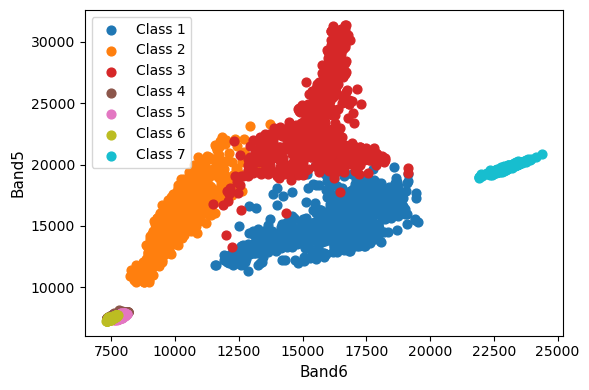

In [118]:
# Define the bands to plot (you can choose any two)
x_band = 'band6'
y_band = 'band5'

# Define colors for each label using a colormap
cmap = plt.get_cmap('tab10', 7)  # 7 classes in total

# Create the plot
plt.figure(figsize=(6, 4))

# Plot data for each class label
for label in sorted(training_data['labels'].unique()):
    class_data = training_data[training_data['labels'] == label]
    plt.scatter(
        class_data[x_band], 
        class_data[y_band], 
        label=f'Class {label}', 
        color=cmap(label - 1),
        s=40)

# Customize the plot
plt.xlabel(f'{x_band.capitalize()}', fontsize=11)
plt.ylabel(f'{y_band.capitalize()}', fontsize=11)
plt.legend(loc=0)
plt.tight_layout()

# Show the plot
plt.show()

This is really useful. It looks like we should have no problem distinguishing between Class 1 (cleared), Class 2 (forest), Class 3 (grass), and Class 7 (sand). However, it might be difficult distinguishing between our different water classes 4, 5, and 6 (i.e. lake, ocean, and river). 

## M-statistic

The M-statistic is a measure of class separability, often used in remote sensing and classification analysis. It evaluates how distinct two classes are by comparing the distance between their mean values relative to their standard deviations.

Below is a function to compute the M-statistic for two classes at a time.

In [154]:
def m_statistic(c1, c2):
    # Extract data for Class 1 and Class 2
    class_1 = training_data[training_data['labels'] == c1][['band1', 'band2', 'band3', 'band4', 'band5', 'band6', 'band7']]
    class_2 = training_data[training_data['labels'] == c2][['band1', 'band2', 'band3', 'band4', 'band5', 'band6', 'band7']]
    
    # Compute means and standard deviations for each band
    mean_1 = class_1.mean()
    mean_2 = class_2.mean()
    
    std_1 = class_1.std()
    std_2 = class_2.std()
    
    # Compute M-statistic for each band
    M_statistic = (abs(mean_1 - mean_2)) / np.sqrt(std_1**2 + std_2**2)
    
    # Display results
    return(M_statistic)

In [156]:
m_statistic(1, 2)

band1    2.906937
band2    3.384646
band3    2.807394
band4    3.653126
band5    0.064677
band6    3.030287
band7    3.367483
dtype: float64

````{margin}
```{note}
M < 1: Poor separability.
1 ≤ M ≤ 2: Moderate separability.
M > 2: Good separability.
```
````

The M-Statistic confirms that there should be good separability between Classes 1 (cleared) and 2 (forest) for all the bands except Band 5. 

In [157]:
m_statistic(4, 5)

band1    0.471940
band2    0.810753
band3    1.106840
band4    1.339791
band5    0.709128
band6    0.201126
band7    0.282104
dtype: float64

In contrast, the M-Statistic shows that Classes 4 (lake) and 5 (ocean) are going to be difficult to separate. If we are, we might have best success using Band 3 and 4. 